In [1]:
#This notebook is going to use the accelwattch_results to look at the Accelwattch power_ubench
#While the accelwattch_power_ubench.csv was generated from the util/accelwattch/gen_sim_power_csv.py program directly


In [2]:
import csv
import os 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
benchmarks = []
basedir = os.getcwd()
reportsdir = os.path.join(basedir,"accelwattch_results")
os.listdir(reportsdir)



['accelwattch_ubench_1iter.csv', 'accelwattch_ubench_2iter.csv']

In [38]:
iter_1_df = pd.read_csv(os.path.join(reportsdir,'accelwattch_ubench_1iter.csv'))
iter_2_df = pd.read_csv(os.path.join(reportsdir,'accelwattch_ubench_2iter.csv'))
iter_1_df = iter_1_df.rename(columns={"Unnamed: 0": "KERNEL_NAME"})
iter_2_df = iter_2_df.rename(columns={"Unnamed: 0": "KERNEL_NAME"})
iter_1_df.head()


,KERNEL_NAME,"IBP,","ICP,","DCP,","TCP,","CCP,","SHRDP,","RFP,","INTP,","FPUP,",...,"SCHEDP,","L2CP,","MCP,","NOCP,","DRAMP,","PIPEP,","IDLE_COREP,",CONSTP,STATICP,kernel_avg_power
0,ACT_CORE1_1_16_32_k1,0.019536,0.0,0.233142,0.0,0.0,0.0,0.589161,0.250562,0.0,...,0.055081,0.157573,0.617735,0.118661,0.617735,0.051965,22.1980,32.3252,0.611924,57.2509
1,ACT_CORE1_1_1_32_k1,0.001221,0.0,0.014660,0.0,0.0,0.0,0.036778,0.015660,0.0,...,0.003443,0.010042,0.554480,0.007610,0.554480,0.003248,22.5968,32.3252,0.038245,55.6086
2,ACT_CORE1_1_32_32_k1,0.039072,0.0,0.449702,0.0,0.0,0.0,1.178680,0.501124,0.0,...,0.110163,0.309092,0.677657,0.231269,0.677657,0.103930,21.7727,32.3252,1.223850,58.9732
3,ACT_CORE1_1_48_32_k1,0.058583,0.0,0.577235,0.0,0.0,0.0,1.768470,0.751685,0.0,...,0.165170,0.434559,0.696814,0.317824,0.696814,0.154560,21.3474,32.3252,1.835770,60.5385
4,ACT_CORE1_1_64_32_k1,0.077878,0.0,0.706856,0.0,0.0,0.0,2.355840,1.002250,0.0,...,0.219541,0.559359,0.716926,0.403712,0.716926,0.205186,20.9221,32.3252,2.447690,62.1028


In [40]:
# Calculate the difference
power_difference = iter_2_df['kernel_avg_power'] - iter_1_df['kernel_avg_power']

# Create a new DataFrame with the difference and raw avg power
result_df = pd.DataFrame({
    'Kernel': iter_1_df['KERNEL_NAME'],
    'Power_Difference': power_difference,
    'Avg_Power_Iter_1': iter_1_df['kernel_avg_power'],
    'Avg_Power_Iter_2': iter_2_df['kernel_avg_power']
})

# Print the top 5 and bottom 5 rows
top_bottom_rows = pd.concat([result_df.nlargest(5, 'Power_Difference'), result_df.nsmallest(5, 'Power_Difference')])
top_bottom_rows

,Kernel,Power_Difference,Avg_Power_Iter_1,Avg_Power_Iter_2
92,mix4_1_k1,17.5477,99.8903,117.438
13,add_mem_2_1_k1,17.5110,100.7150,118.226
48,BRANCHING1_1_k1,16.3309,87.1441,103.475
90,mix2_1_k1,13.3761,88.6709,102.047
15,BE_DP_FP_DIV_1_k1,12.9600,124.3230,137.283
30,BE_MEM_DRAM_Acss_1_k1,-8.1940,114.9680,106.774
18,BE_HP_FP_ADD_1_k1,0.0000,62.7000,62.700
20,BE_HP_FP_DIV_1_k1,0.0000,62.7000,62.700
22,BE_HP_FP_MAD_1_k1,0.0000,62.7000,62.700
24,BE_HP_FP_MUL_1_k1,0.0000,62.7000,62.700


In [4]:
def aggregate_predicted_values(predicted_df):
    predicted_df['ALUP']=predicted_df['INTP']+predicted_df['INT_MULP']
    predicted_df['FPU_DPUP']=predicted_df['FPUP']+predicted_df['FP_MULP']+predicted_df['DPUP']+predicted_df['DP_MULP']
    predicted_df['SFUP']=predicted_df['FP_SQRTP']+predicted_df['FP_LGP']+predicted_df['FP_SINP']+predicted_df['FP_EXP']
    predicted_df['L1D_SHRDP']=predicted_df['DCP']+predicted_df['SHRDP']
    predicted_df['ICACHE_CCACHEP']=predicted_df['ICP']+predicted_df['CCP']
    predicted_df['L2_NOCP']=predicted_df['L2CP']
    predicted_df['DRAM_MCP']=predicted_df['DRAMP']
    predicted_df['OTHERP']=predicted_df['IBP']+predicted_df['TEXP']+predicted_df['SCHEDP']+predicted_df['PIPEP']
    return predicted_df
def process_df_dict(df_dict):
    if 'predicted' in df_dict:
        df_dict['predicted']['Unnamed: 0'] = df_dict['predicted']['Unnamed: 0'].str.replace('+','',regex=False)
        df_dict['predicted'] = df_dict['predicted'].rename(columns={"Unnamed: 0": "KERNEL_NAME"})
        df_dict['predicted'] = df_dict['predicted'].sort_values('KERNEL_NAME').reset_index(drop=True)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('-','_',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('rodinia_3.1_','',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('i_q','iq',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('perf_test_','',regex=False)
        df_dict['predicted'] = aggregate_predicted_values(df_dict['predicted'])
        # Replace with '_P'
        # df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('P$', '',regex=True)  
    if 'measured' in df_dict:
        df_dict['measured'] = df_dict['measured'].sort_values('Unnamed: 0')
        m_df = df_dict['measured']
        m_df = m_df[~ m_df['Unnamed: 0'].str.contains("pathfinder")].reset_index(drop=True)
        m_df = m_df.rename(columns={"Unnamed: 0": "Kernel Names"})
    #Either add measured data or just return predictions
    if 'predicted' in df_dict and 'measured' in df_dict:
        combined_df = pd.merge(df_dict['predicted'], m_df, left_on='KERNEL_NAME', right_on='Kernel Names')
        return combined_df
    elif 'predicted' in df_dict:
        return df_dict['predicted']
def get_data(sim_target,reportsdir=reportsdir):
    df_dict = {}
    for file in os.listdir(reportsdir):
        df = pd.read_csv(os.path.join(reportsdir,file))
        df.columns = df.columns.str.replace(',','')
        if 'hw_power' in file and any(target in sim_target for target in ["QV100", "Tesla"]):
            df_dict["measured"]=df
        elif sim_target in file:
            df_dict['predicted']=df
    return process_df_dict(df_dict)


In [5]:
custom_colors = ["#D9D9D9","#A5A5A5","#F7C8A8","#8CB9E1","#868686","#A97655","#D68B58","#BAD5ED","#637492","#F2A46F","#646A71","#C5CEDA","#7C8796"]
custom_colors.reverse()

# Define the columns for stacking
stack_columns = 

In [26]:
def create_component_breakdown_graph(predicted_df, title="", value_format="raw",
                                     stack_columns=stack_columns, colors=None,
                                     height=6, width=None, legend=True, ylimit=None):
    '''
    Description: Create a stacked bar graph with particular setups similar to graphs from AccelWattch paper
    '''
    if stack_columns is None:
        stack_columns = ['CONSTP', 'STATICP', 'IDLE_COREP','RFP', 'ALUP', 'FPU_DPUP', 'SFUP', 'TENSORP', 'L1D_SHRDP', 'ICACHE_CCACHEP', 'L2_NOCP', 'DRAM_MCP', 'OTHERP']

    if colors is None:
        colors = sns.color_palette("colorblind", n_colors=len(stack_columns))

    # Set the x-axis labels
    x_labels = predicted_df['KERNEL_NAME']

    # Set the values for each stacked column
    stack_values = predicted_df[stack_columns].values.T
    x_axis = np.arange(len(stack_values[0]))
    if len(x_axis) == 0:
        return None

    num_bars = len(x_axis)
    bar_width = 0.7
    bar_offset = 0
    annotation_threshold = predicted_df[stack_columns].sum(axis=1).mean() / 12
    print(f"My threshold is {annotation_threshold}")

    # Plot the stacked bar graph using Seaborn
    plt.figure(figsize=(num_bars * bar_width * 1.5 if width is None else width, height))
    bottom = None
    for i, column in enumerate(stack_columns):
        sns.barplot(x=x_axis, y=stack_values[i],
                    bottom=bottom,
                    label=column, color=colors[i],
                    errorbar=None)  # Disable confidence intervals

        if value_format == "percentage":
            for j, val in enumerate(stack_values[i]):
                if val >= annotation_threshold:
                    plt.text(x_axis[j], bottom[j] if bottom is not None else 0,
                             f"{(val / predicted_df['kernel_avg_power'].iloc[j]) * 100:.1f}%",
                             ha='center', va='bottom', color="black",
                             bbox={'boxstyle': 'round,pad=0.1', 'facecolor': 'lightgray',
                                   'edgecolor': 'gray', 'alpha': 0.7})
        elif value_format == "raw":
            for j, val in enumerate(stack_values[i]):
                if val >= annotation_threshold:
                    plt.text(x_axis[j], bottom[j] if bottom is not None else 0,
                             f"{val:.2f}", ha='center', va='bottom', color="black",
                             bbox={'boxstyle': 'round,pad=0.1', 'facecolor': 'lightgray',
                                   'edgecolor': 'gray', 'alpha': 0.7})
        if bottom is None:
            bottom = np.array(stack_values[i])
        else:
            bottom += np.array(stack_values[i])

    # Rotate the x-labels by 45 degrees and align them to the left
    plt.xticks(x_axis, x_labels, rotation=-22.5, ha='left')

    # Set y-axis limit if specified
    if ylimit is not None:
        plt.ylim(0, ylimit)

    # Add labels and title
    plt.xlabel('Kernel Name')
    plt.ylabel('Power (W)')
    plt.title(title)

    if legend:
        # Add legend with reversed order
        plt.legend(title="Legend", loc='upper right', bbox_to_anchor=(1+(2.5/num_bars), 1), markerscale=10)

    return plt

In [27]:
power_ubench_df = get_data("accelwattch_ubench_1iter.csv")
power_ubench_df = power_ubench_df[power_ubench_df.KERNEL_NAME != 'BE_HP_FP_ADD_k1']
power_ubench_df

,KERNEL_NAME,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,FPUP,...,STATICP,kernel_avg_power,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,ACT_CORE1_1_16_32_k1,0.019536,0.0,0.233142,0.0,0.0,0.000000,0.589161,0.250562,0.000000,...,0.611924,57.2509,0.391570,0.000000,0.00000,0.233142,0.0,0.157573,0.617735,0.126582
1,ACT_CORE1_1_1_32_k1,0.001221,0.0,0.014660,0.0,0.0,0.000000,0.036778,0.015660,0.000000,...,0.038245,55.6086,0.024473,0.000000,0.00000,0.014660,0.0,0.010042,0.554480,0.007911
2,ACT_CORE1_1_32_32_k1,0.039072,0.0,0.449702,0.0,0.0,0.000000,1.178680,0.501124,0.000000,...,1.223850,58.9732,0.783140,0.000000,0.00000,0.449702,0.0,0.309092,0.677657,0.253165
3,ACT_CORE1_1_48_32_k1,0.058583,0.0,0.577235,0.0,0.0,0.000000,1.768470,0.751685,0.000000,...,1.835770,60.5385,1.174710,0.000000,0.00000,0.577235,0.0,0.434559,0.696814,0.378313
4,ACT_CORE1_1_64_32_k1,0.077878,0.0,0.706856,0.0,0.0,0.000000,2.355840,1.002250,0.000000,...,2.447690,62.1028,1.566263,0.000000,0.00000,0.706856,0.0,0.559359,0.716926,0.502605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,mix2_1_k1,0.323210,0.0,4.670870,0.0,0.0,0.116372,9.215650,3.056750,1.947500,...,11.204800,88.6709,4.110790,2.559833,0.35379,4.787242,0.0,3.616250,2.527661,2.573380
95,mix3_1_k1,0.166670,0.0,5.059540,0.0,0.0,0.126070,4.764850,1.941970,1.281260,...,9.278010,79.6453,2.332307,1.281260,0.00000,5.185610,0.0,3.887390,2.690206,1.474060
96,mix4_1_k1,0.468839,0.0,5.655760,0.0,0.0,0.428940,13.109500,4.603470,4.755090,...,12.389900,99.8903,4.963781,5.982440,0.57718,6.084700,0.0,3.336610,2.639878,3.493551
97,mul_add_tex_1_1_k1,0.167822,0.0,3.072940,0.0,0.0,0.000000,4.224500,1.549820,1.431070,...,9.910950,76.5946,1.868767,1.865175,0.00000,3.072940,0.0,4.245530,1.502200,1.209760


<h1>Looking Through My Microbench </h1>

In [46]:
dp_tensor_df = power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains('DP_F') | power_ubench_df.KERNEL_NAME.str.contains('TENSOR_1')]
dp_tensor_df

,KERNEL_NAME,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,FPUP,...,STATICP,kernel_avg_power,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
12,BE_DP_FP_ADD_1_k1,0.140782,0.0,3.875310,0.0,0.0,0.0,4.44383,1.422890,0.000000,...,9.17924,77.1668,2.338130,1.917330,0.00000,3.875310,0.0,3.589190,1.676400,0.879272
13,BE_DP_FP_DIV_1_k1,0.943313,0.0,1.237950,0.0,0.0,0.0,27.35520,8.471940,2.842100,...,18.88020,124.3230,12.076820,12.510440,1.10868,1.237950,0.0,1.159674,0.909971,5.881513
14,BE_DP_FP_MAD_1_k1,0.133914,0.0,3.875310,0.0,0.0,0.0,4.55569,0.905319,0.000000,...,9.09501,75.4091,1.820559,0.668605,0.00000,3.875310,0.0,3.609420,1.676400,0.844025
15,BE_DP_FP_MUL_1_k1,0.133914,0.0,3.875310,0.0,0.0,0.0,4.18912,1.034710,0.000000,...,9.00154,75.1085,1.949950,0.573090,0.00000,3.875310,0.0,3.656040,1.676400,0.854137
88,TENSOR_1_k1,0.224667,0.0,4.218525,0.0,0.0,0.0,5.30657,2.539710,0.810861,...,17.84085,105.5090,3.628853,0.810861,0.00000,4.218525,0.0,3.314090,25.048930,1.395058
89,TENSOR_1_k2,0.067142,0.0,7.504530,0.0,0.0,0.0,2.65612,0.613541,0.002758,...,28.59010,85.3568,1.150165,0.002758,0.00000,7.504530,0.0,3.188650,2.496407,0.438142


My threshold is 7.539911311111111


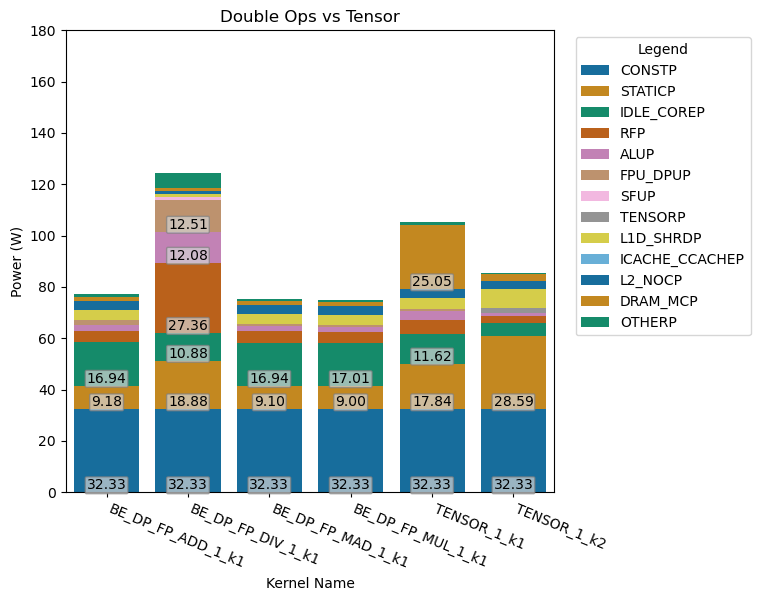

In [48]:
create_component_breakdown_graph(dp_tensor_df,"Double Ops vs Tensor", legend=True,ylimit=180).show()

My threshold is 6.2012675963406885


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

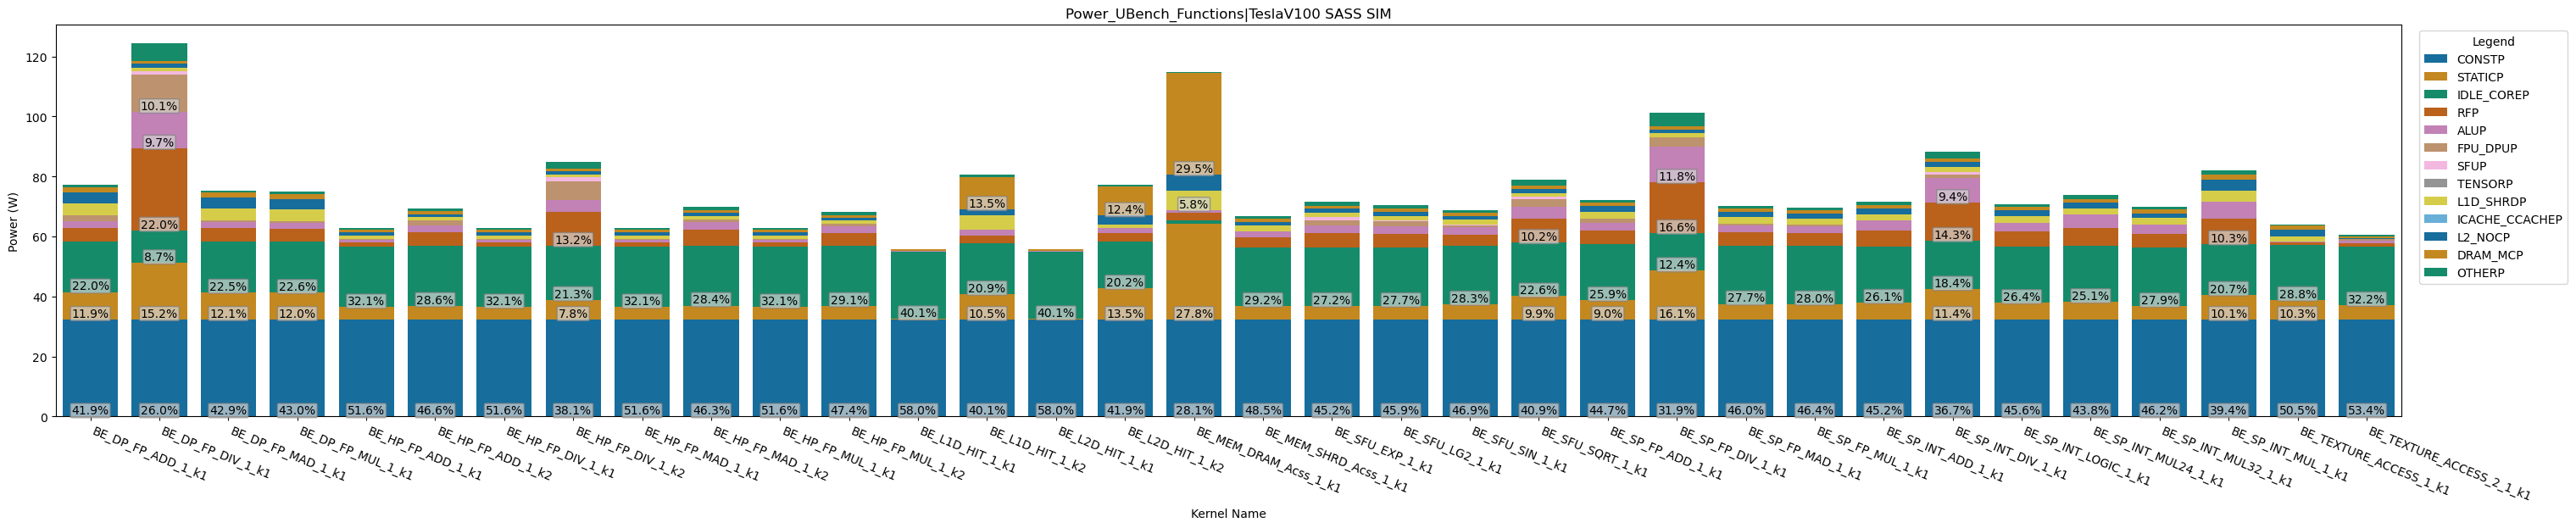

In [49]:
create_component_breakdown_graph(power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("BE")],"Power_UBench_Functions|TeslaV100 SASS SIM",value_format="percentage")

My threshold is 6.194491197849463


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

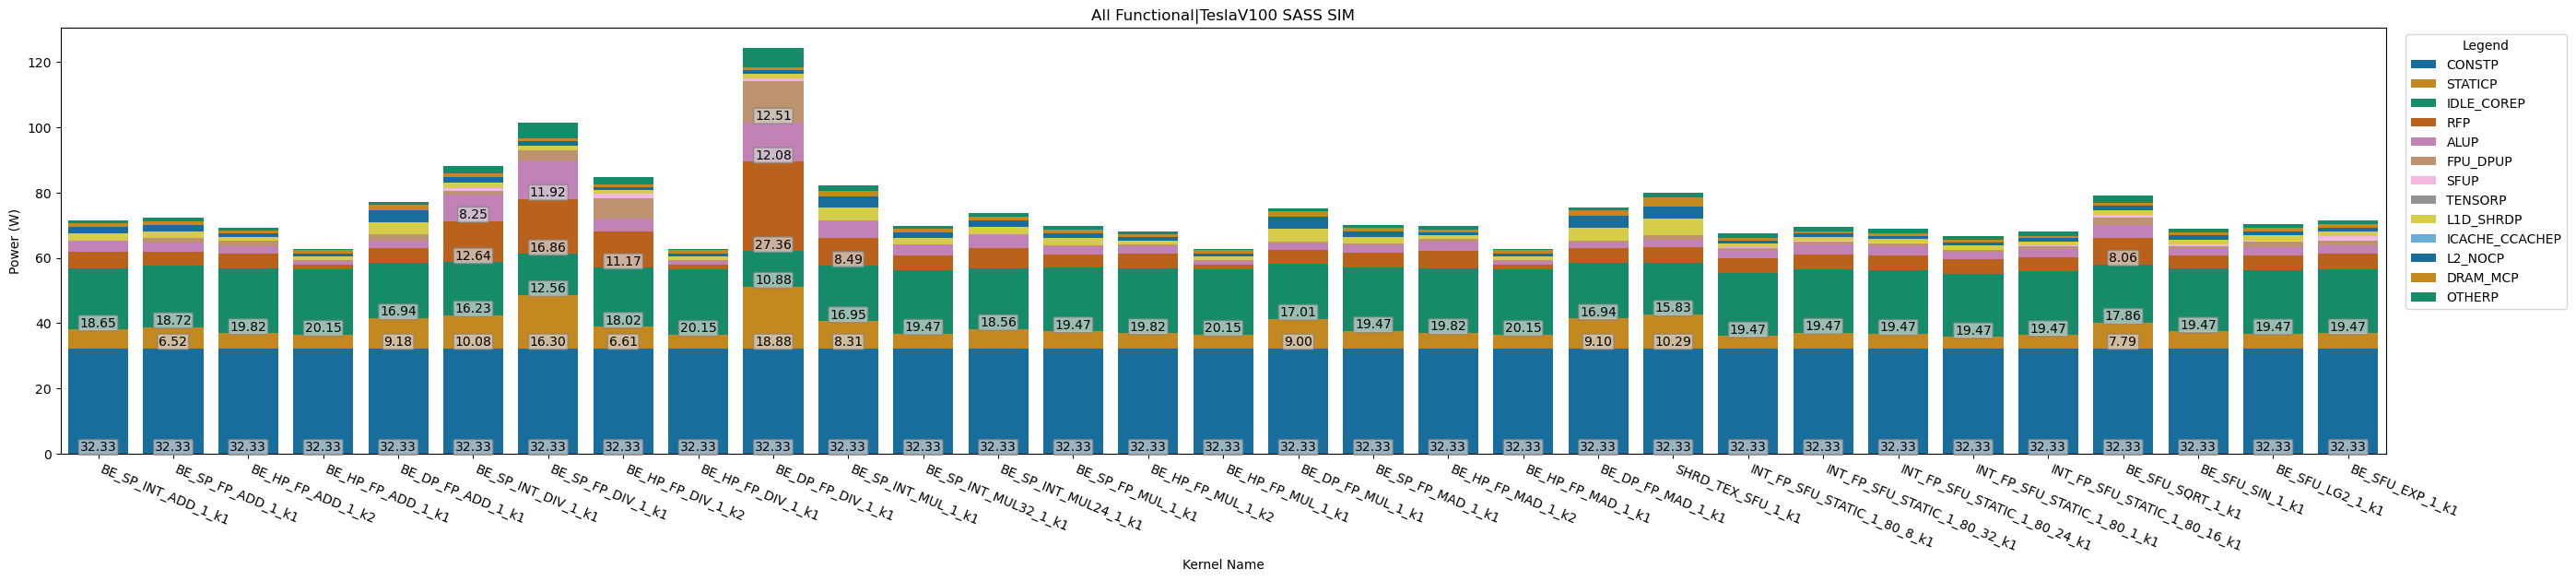

In [50]:
functions_df = pd.concat([power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("ADD")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("DIV")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("MUL")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("MAD")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("SFU")].sort_index(ascending=False),])

create_component_breakdown_graph(functions_df,"All Functional|TeslaV100 SASS SIM")

My threshold is 6.403409838666668


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

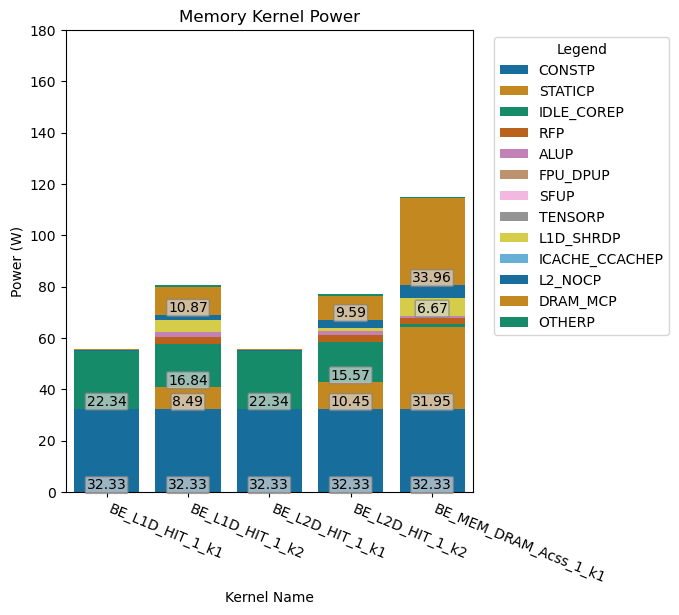

In [51]:
scaling = 0.8
create_component_breakdown_graph(power_ubench_df[#power_ubench_df.KERNEL_NAME.str.contains("ACC")|
                                                 power_ubench_df.KERNEL_NAME.str.contains("MEM_DRAM")|
                                                 (power_ubench_df.KERNEL_NAME.str.contains("BE_L")&
                                                    ~power_ubench_df.KERNEL_NAME.str.contains("HIT_k1"))],
                                 "Memory Kernel Power",#"Power_UBench_Memory|TeslaV100 SASS SIM",
                                    # legend=False,
                                 height=6,ylimit=180)

My threshold is 5.854095460015723


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

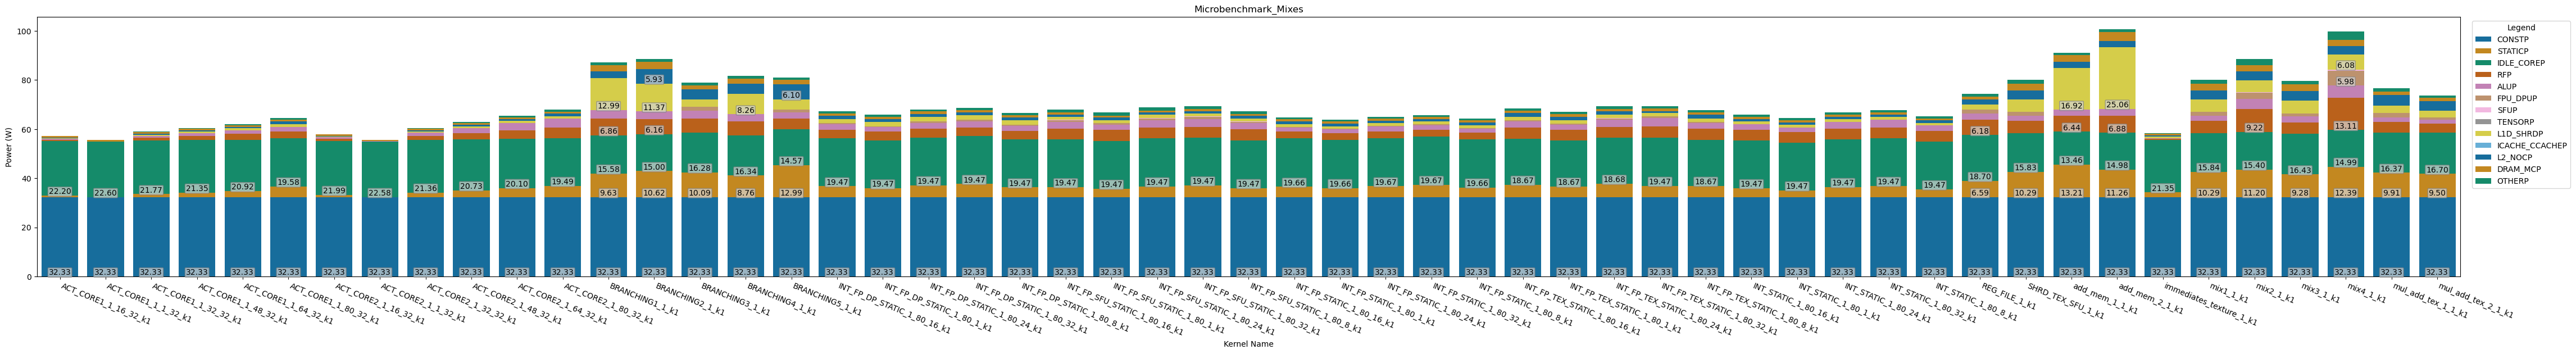

In [52]:
create_component_breakdown_graph(power_ubench_df[~power_ubench_df.KERNEL_NAME.str.contains("BE")
                                                 &~power_ubench_df.KERNEL_NAME.str.contains("TENSOR")],
                                 "Microbenchmark_Mixes")#"Power_UBench_Mix/Tensor|TeslaV100 SASS SIM")

In [ ]:
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    r = int(hex_code[0:2], 16)
    g = int(hex_code[2:4], 16)
    b = int(hex_code[4:6], 16)
    return r, g, b

def find_suitable_text_color(palette_colors_rgb):
    def contrast(rgb1, rgb2):
        # Calculate the contrast ratio between two RGB colors
        lum1 = 0.2126 * rgb1[0] + 0.7152 * rgb1[1] + 0.0722 * rgb1[2]
        lum2 = 0.2126 * rgb2[0] + 0.7152 * rgb2[1] + 0.0722 * rgb2[2]
        if lum1 > lum2:
            return (lum1 + 0.05) / (lum2 + 0.05)
        else:
            return (lum2 + 0.05) / (lum1 + 0.05)

    def find_suitable_contrast_color(base_rgb, palette_colors_rgb):
        max_contrast = 0
        best_color = None
        for color_rgb in palette_colors_rgb:
            current_contrast = contrast(base_rgb, color_rgb)
            if current_contrast > max_contrast:
                max_contrast = current_contrast
                best_color = color_rgb
        return best_color

    # Create a dictionary to store the suitable text color for each color in the palette
    text_colors_dict = {}

    # Find the suitable text color for each color in the palette
    for base_color in palette_colors_rgb:
        text_color = find_suitable_contrast_color(base_color, palette_colors_rgb)
        text_colors_dict[base_color] = text_color

    return text_colors_dict


# Convert hex colors to RGB format
palette_colors_rgb = [hex_to_rgb(color_hex) for color_hex in custom_colors]

# Find the suitable text color for each color in the palette
text_colors_dict = find_suitable_text_color(palette_colors_rgb)

print("Text Colors for Palette:")
for base_color, text_color in text_colors_dict.items():
    print(f"Base Color (RGB): {base_color}, Text Color (RGB): {text_color}")


<h1> Data Type exploration </h1>

In [ ]:
ubench_datatype_df = get_data("accelwattch_ubench_datatype_volta_sass_sim")#accelwattch_power_ubench_datatype_sass_sim")# 
ubench_datatype_df = ubench_datatype_df[(ubench_datatype_df.KERNEL_NAME != 'BE_HP_FP_ADD_k1') & (ubench_datatype_df.KERNEL_NAME != 'BE_HP_FP_MUL_k1')]

In [ ]:
add_ubench_datatype_df = ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("ADD")]
datatype_df = pd.concat([add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("INT")
                                         #& ~ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")
                                        ].sort_index(ascending=False),
                          add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("HP")].sort_index(ascending=False),
                          add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")].sort_index(ascending=False),
                          add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("DP")].sort_index(ascending=False),
                        ])
create_component_breakdown_graph(datatype_df,
                                 "Corrected Datatypes Across Add Kernels",value_format="raw",
                                 
                                 height=6,ylimit=180)
#WHEN MEASURED
# BE_SP_INT_ADD_2000000000    146.984032
# BE_HP_FP_ADD_2000000000     158.188341
# BE_SP_FP_ADD_2000000000     141.554018
# BE_DP_FP_ADD_2000000000     139.558501

# INT     98.807
# HP     145.082
# SP     127.304
# DP     122.942

In [ ]:
datatype_df = pd.concat([ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("ADD")].sort_index(ascending=False),
                          # ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("DIV")].sort_index(ascending=False),
                          # ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("MUL")].sort_index(ascending=False),
                        ])
create_component_breakdown_graph(datatype_df,
                                 "Compute Power of Add Operations Across Datatypes",
                                 stack_columns=['INTP','INT_MULP','FPUP','FP_MULP','DPUP','DP_MULP'],
                                 # value_format="raw", 
                                 colors=custom_colors[4:])

In [ ]:
mul_ubench_datatype_df = ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("MUL")]
datatype_df = pd.concat([mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("INT")
                                         #& ~ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")
                                        ].sort_index(ascending=False),
                          mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("HP")].sort_index(ascending=False),
                          mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")].sort_index(ascending=False),
                          mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("DP")].sort_index(ascending=False),
                        ])
create_component_breakdown_graph(datatype_df,
                                 "Corrected Datatypes Across Multiply Kernels",value_format="raw",                                 
                                 height=6,ylimit=180)
datatype_df[['KERNEL_NAME','kernel_avg_power']]

In [ ]:
binaries = ubench_datatype_df.KERNEL_NAME.str.replace("_k[0-9]$","",regex=True).to_list()
for binary in sorted(list(set(binaries))):
    iters = 100 #100 is original #1000000 was for exec time significance
    if any(item in binary for item in ["DIV","_mem","mix",'TENSOR']):
        iters /= 10
    if "DRAM" in binary:
        iters /= 100
    print(binary,int(iters))